<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-RigobertoVega/blob/main/Actividad_Semanal_7_Regresiones_y_K_means_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

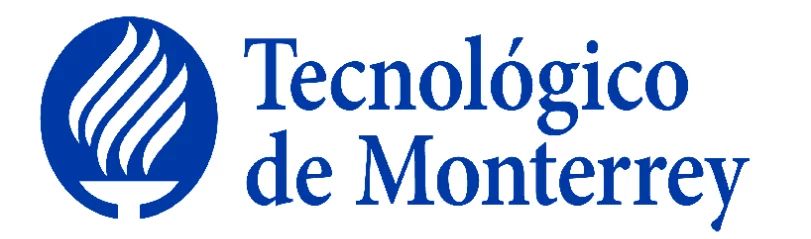
#**Actividad Semanal -- 7 Regresiones y K means**

##Rigoberto Vega Escudero, A01793132

##Materia: Ciencia De Datos

##Profesor:Maria De La Paz Rico Fernandez

##02/Noviembre/2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [4]:
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [6]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [7]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [9]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

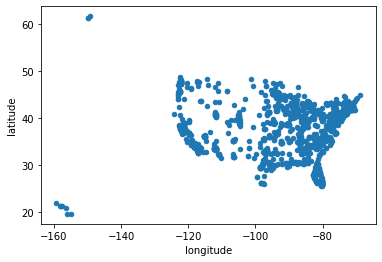

In [10]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [11]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [13]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [14]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [15]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [16]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

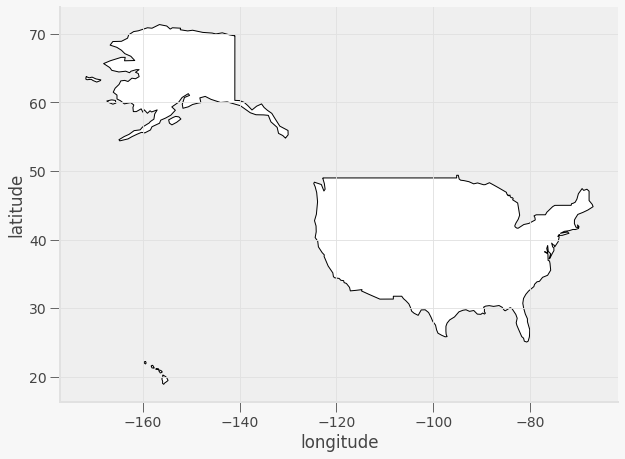

In [17]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

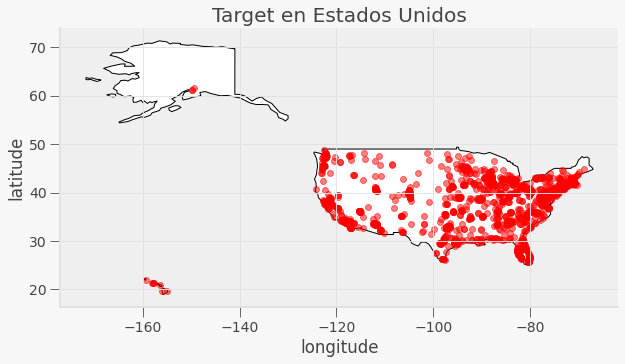

In [18]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

- Encuentra las latitudes y longitudes de los almacenes, ¿que ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estara?
- ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente?


- ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
- ¿Consideras importante que se grafique en un mapa?, ¿por qué?
Agrega las conclusiones

In [19]:
X = df[["latitude","longitude"]]
X

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422
...,...,...
1834,43.034293,-88.176840
1835,42.989604,-88.259806
1836,42.846799,-106.264166
1837,41.162019,-104.800048


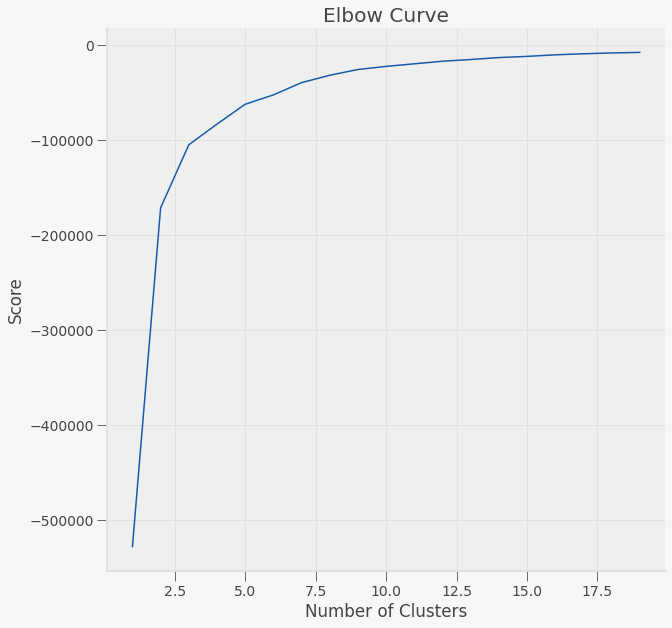

In [20]:
from sklearn.cluster import KMeans
X = df[["longitude","latitude"]]

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.subplots(figsize=(10,10))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Segun la grafica de Elbow, nos dice que 3 clusters seria la mejor opcion.

In [21]:


kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1]))
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates")
gdf_C



,0,1,Coordinates
0,-93.327172,37.980063,POINT (-93.32717 37.98006)
1,-78.569908,37.789554,POINT (-78.56991 37.78955)
2,-118.624473,37.487342,POINT (-118.62447 37.48734)


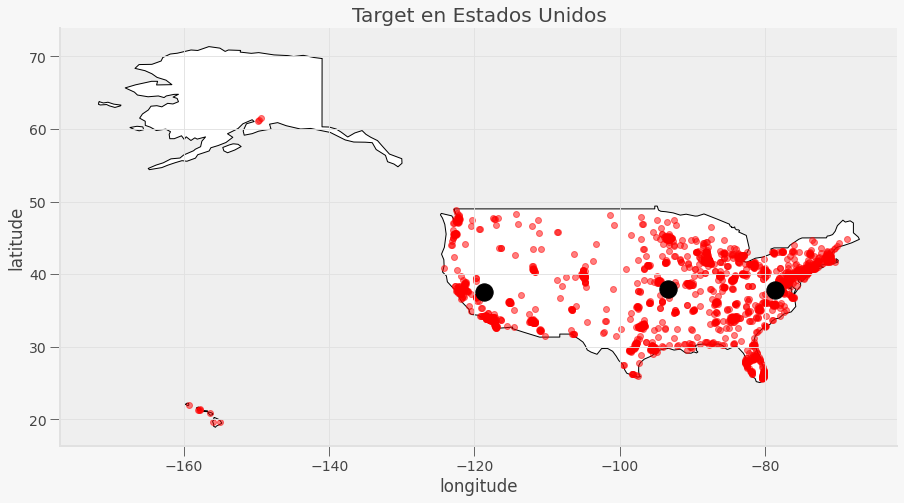

In [22]:
fig, gax = plt.subplots(figsize=(15,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [23]:
#Conteo de tiendas por cada cluster
latlong['kmeans'] = kmeans.labels_
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    826
0    628
2    385
Name: kmeans, dtype: int64

In [24]:
gdf_C

,0,1,Coordinates
0,-93.327172,37.980063,POINT (-93.32717 37.98006)
1,-78.569908,37.789554,POINT (-78.56991 37.78955)
2,-118.624473,37.487342,POINT (-118.62447 37.48734)


In [25]:
from pandas.core.internals.concat import concat_arrays

print(gdf_C[0][0])
print(gdf_C[1][0])

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0])
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)

-93.32717230430622
37.98006260590112
37.98006260590112, -93.32717230430622
37.789554004474006, -78.56990807484885
37.48734203064935, -118.62447331844157


In [29]:
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application")
Locations = [Location1, Location2, Location3]
for i in Locations:
  location = geolocator.reverse(i)

  print(location.address)

locations1 = geolocator.reverse(Location1)
locations2 = geolocator.reverse(Location2)

distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el primer y segundo almacén : ", distancia1, " Millas \n")
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el segundo y tercer almacén : ", distancia2, " Millas \n")

Hickory County, Missouri, United States
Langhorne Road, Totier Hills, Albemarle County, Virginia, 22946, United States
Paradise Estates, Mono County, California, United States

Distancia entre el primer y segundo almacén :  805.9209470497035  Millas 

Distancia entre el segundo y tercer almacén :  2179.654449831999  Millas 



#Preguntas.

Encuentra las latitudes y longitudes de los almacenes, 
- ¿que ciudad es?

Las ciudades donde estarán ubicadas los almacenes serán:

1. Missouri, United States
2. California, United States
3. Virginia, United States

- ¿a cuantas tiendas va surtir?

El primer almacén surtía a 826 tiendas, el segundo a 628 y el tercero a 385.

- ¿sabes a que distancia estara?

La distancia entre el primer y segundo almacén es de: 805.92 Millas.

La distancia entre el segundo y tercer almacén es de: 2179.65 Millas.

- ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente?

Utilizé eñ método del codo. El cual se utiliza para determinar el número óptimo de conglomerados en el agrupamiento de k-medias. El método del codo traza el valor de la función de costo producida por diferentes valores de k. Como sabe, si k aumenta, la distorsión promedio disminuirá, cada grupo tendrá menos instancias constituyentes y las instancias estarán más cerca de sus respectivos centroides. Sin embargo, las mejoras en la distorsión promedio disminuirán a medida que aumente k. El valor de k en el que la mejora en la distorsión disminuye más se denomina codo, en el que debemos dejar de dividir los datos en grupos adicionales.

- ¿qué librerías nos pueden ayudar a graficar este tipo de datos?

No creo que pudiera elegir otras más que las utilizadas en este ejercicio, como matplotlib y geopandas que en definitiva le dieron una mejor presentación a los datos. Además que nos pudiera ayudar es la de geodesic que me ayudo en la parte de la obtención de las direcciones exactas, etc. En definitiva la conjunción de todas le dio una gran presentación a esta práctica.

- ¿Consideras importante que se grafique en un mapa?, ¿por qué?

Si. Creo presentar los datos bajo el grafico que mejor se adapta a su escencia es la mejor manera de representar cualquier informacion, por los visuales y el entendimiento que le dan a una audiencia que talvez no sea tan técnica con estos datos. 



#Conclusiones

En conclusión, aprendí bastante acerca del método Kmeans, vaya herramienta. Como agrupar los datos para buscar albergar una concentración de estos. Además, que K-manes es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en k grupos basándose en sus características. El poder aplicarlo al caso de target creo dio un enfoque perfecto para cómo utilizar la herramienta, además de revisando los códigos de referencia, como se usan para el tratamiento de imágenes es fascinante, en definitiva un modelo que merece más foco de atención de mi parte.

#Referencias

- VanderPlas, J.  Python data science handbook: Essential tools for working with data. " O'Reilly Media, Inc.".

- GeoPy. (2022). Welcome to GeoPy’s documentation! Obtenido de https://geopy.readthedocs.io/en/stable/
- NAIK, K. (2020). P2: sklearn K-Means (Elbow and Silhouette Method). Obtenido de https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook
- Geeks for Geeks. (2022, 08 22). Elbow Method for optimal value of k in KMeans. Retrieved from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
- Dangeti, P. (2017). The elbow method. In Statistics for Machine Learning. Birmingham, UK: O´REILLY.

